## 📊 Visualisation et analyse des performances CPU vs GPU

Cette section présente une série de graphiques comparant les performances du CPU et du GPU sur différents types de charges de calcul, notamment des multiplications matricielles et des réseaux neuronaux convolutionnels.

Les mesures collectées précédemment sont ici transformées en visualisations afin de mieux observer :

- la latence d’exécution selon la taille des données,
- le débit de calcul atteint,
- la consommation énergétique estimée,
- et, pour le GPU, la répartition du temps entre transferts mémoire et calcul effectif.

Ces graphiques permettent de mettre en évidence les différences de comportement entre les architectures CPU et GPU. On peut ainsi identifier les situations où les coûts de transfert mémoire deviennent significatifs, ainsi que celles où le parallélisme massif du GPU offre un avantage décisif.

L’objectif n’est pas seulement de comparer des chiffres bruts, mais de comprendre **comment la nature du workload influence les performances**, afin de dégager des tendances utiles pour le choix d’architecture dans des scénarios réels (calcul scientifique, traitement d’images, IA, etc.).

👉 Les visualisations servent donc de support à une interprétation plus globale des performances et de l’efficacité énergétique.


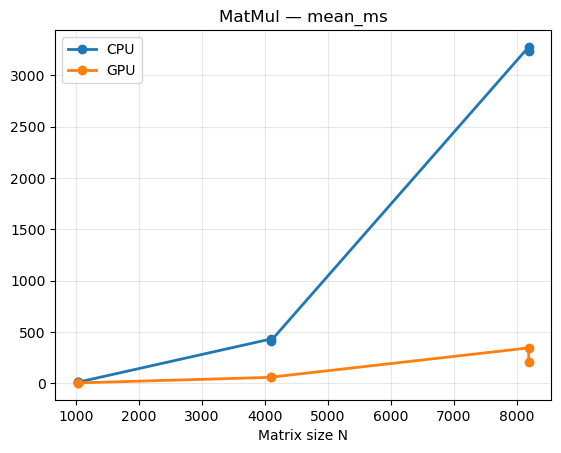

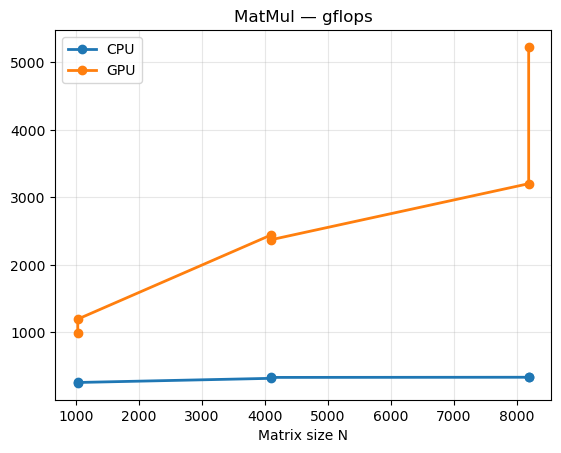

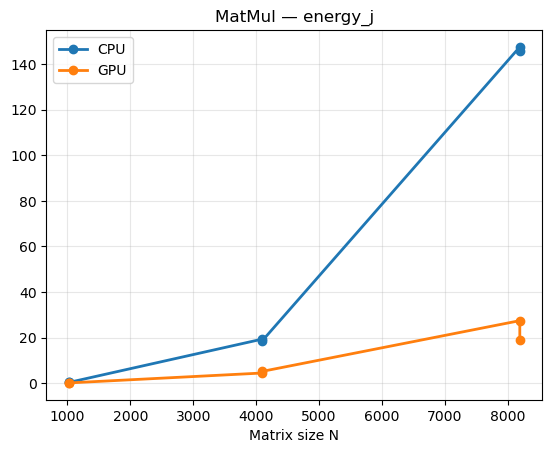

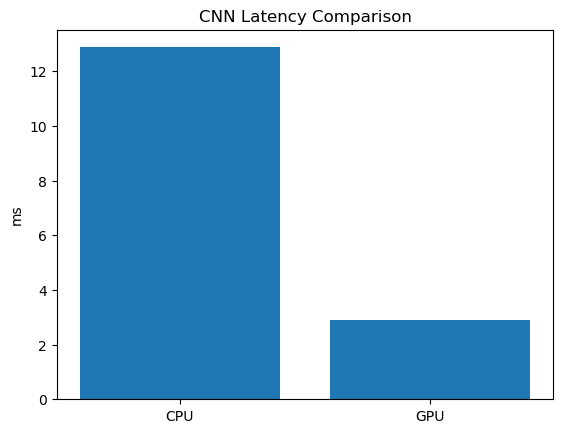

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger données
matmul = pd.read_csv("results/matmul_cpu_gpu_4060.csv")
cnn = pd.read_csv("results/cnn_cpu_gpu_4060.csv")

# ---------- MatMul Latence ----------

metrics = ["mean_ms", "gflops", "energy_j"]

for metric in metrics:

    plt.figure()

    for device in ["cpu", "gpu"]:

        d = matmul[matmul.device == device].copy()

        # 🔥 TRI IMPORTANT
        d = d.sort_values("N")

        plt.plot(
            d["N"],
            d[metric],
            marker="o",
            linewidth=2,
            label=device.upper()
        )

    plt.title(f"MatMul — {metric}")
    plt.xlabel("Matrix size N")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

# ---------- CNN ----------
plt.figure()

labels = ["CPU", "GPU"]
lat = [
    cnn[cnn.device=="cpu"]["mean_ms"].values[0],
    cnn[cnn.device=="gpu"]["mean_ms"].values[0]
]

plt.bar(labels, lat)
plt.title("CNN Latency Comparison")
plt.ylabel("ms")
plt.show()


## 🔍 Comprendre la décomposition du temps GPU (H2D / Compute / D2H)

Les graphiques précédents montrent le temps total d’exécution sur GPU découpé en trois phases. Cette décomposition permet de comprendre **où le temps est réellement dépensé** lors d’un calcul accéléré par GPU.

---

### 🧩 H2D — Host → Device

C’est le **transfert des données du CPU vers le GPU**.

Concrètement :

```
RAM (CPU) → VRAM (GPU)
```

Avant que le GPU puisse calculer, les données doivent être copiées dans sa mémoire. Ce transfert utilise le bus PCIe et peut devenir coûteux, surtout pour de petites opérations.

👉 Si cette phase est dominante, le GPU passe plus de temps à attendre les données qu’à calculer.

---

### ⚙ Compute — calcul GPU

C’est le **temps où le GPU effectue réellement le calcul** :

- multiplication matricielle
- convolution
- inférence réseau neuronal

Cette phase correspond au travail massif parallèle du GPU.

👉 Plus cette portion est grande, mieux le GPU est exploité.

---

### 🔄 D2H — Device → Host

C’est le **transfert des résultats du GPU vers le CPU** :

```
VRAM (GPU) → RAM (CPU)
```

Ce transfert est nécessaire si le résultat doit être affiché, sauvegardé ou traité côté CPU.

---

## ⏱ Temps total GPU

Le temps mesuré pour une opération GPU est donc :

```
Temps total = H2D + Compute + D2H
```

Même si le calcul GPU est très rapide, les transferts mémoire peuvent représenter une part importante du temps total.

---

## 🎯 Interprétation des graphiques

- **Petites tailles de données**  
  → les transferts mémoire dominent  
  → le GPU est sous-utilisé

- **Grandes tailles de données**  
  → le calcul GPU domine  
  → le parallélisme est pleinement exploité

---

## 💡 À retenir

Le GPU est extrêmement rapide pour le calcul…  
mais il faut **minimiser les transferts mémoire** pour en tirer pleinement parti.

Bonnes pratiques :

- traiter de gros batches
- garder les données sur le GPU autant que possible
- éviter les allers-retours CPU ↔ GPU inutiles

---

👉 Cette analyse explique pourquoi le GPU devient réellement avantageux lorsque l’intensité de calcul augmente.


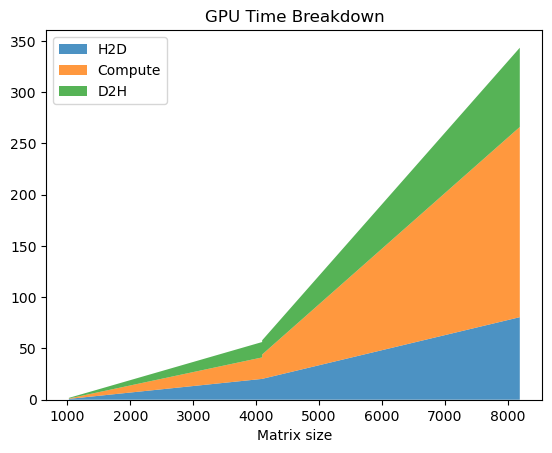

In [3]:
# ---------- GPU decomposition ----------
gpu = matmul[matmul.device == "gpu"].copy()
gpu = gpu.sort_values("N")

plt.figure()

plt.stackplot(
    gpu["N"],
    gpu["h2d_ms"],
    gpu["compute_ms"],
    gpu["d2h_ms"],
    labels=["H2D", "Compute", "D2H"],
    alpha=0.8
)

plt.title("GPU Time Breakdown")
plt.xlabel("Matrix size")
plt.legend(loc="upper left")
plt.show()